### Written by  [Gabriel Borges Pinheiro](https://www.github.com/gabrielbopi)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def db(X):
    return 10 * np.log10(np.abs(X))
def inv_db(X):
    return 10**(X/10)
def dbm(X):
    return 10 * np.log10(np.abs(X)/(1e-3))
def inv_dbm(X):
    return (1e-3) * 10**(X/10)

In [3]:
def bases(D, x, y, z_med=15):
    num_x = int(x/D)
    num_y = int(y/D)
    total = num_x*num_y
    n = np.array([])
    for i in range(num_y):
        for j in range(num_x):
            n = np.append(n, np.array([(j*D)+(D/2),(i*D)+(D/2),z_med])) 
        
    return n.reshape(total,3) , total

def usuário(n, x, y):
    z_med = 1.5 #m
    UE = np.array([])
    for i in range(n):
        UE = np.append(UE,np.array([x*np.random.random(),y*np.random.random(),z_med]))
    return UE.reshape(n,3)

In [4]:
from scipy.io import loadmat

In [5]:
H_q = loadmat("./models/channel.mat")
H=H_q['Hfreq']

In [13]:
np.size(H, axis=0)

4

In [42]:
#Numero de frequencias
n_f = 240
# f = f0 + Δf*(np.arange(n_f)-n_f/2)
H = np.zeros([n_ue,n_bs,n_f],dtype='complex')
# R = np.zeros([3])
# φ = np.zeros([n_ue,n_bs],dtype='float')
for k in range(n_ue):
    for j in range(n_bs):
#         R = UE[k]-BS[i]
        for i in range(n_f):
#             D = np.linalg.norm(R)
            H[k,j,i] = H_q['Hfreq'][ , , i]

#         φ[k][i] = 2*np.pi*(np.random.rand()-0.5)
#         H[k][i] = H[k][i]*np.exp(1j*φ[k][i])

SyntaxError: invalid syntax (<ipython-input-42-7cf171e0827c>, line 12)

#### Calculating parameters

In [44]:
#Espaçamento entre cada BS
gap_bs = 50 #m
#Lados da area de bases (quadrado com bases a cada gap_bs metros)
# BS,n_bs = bases(gap_bs, 100, 100,3)
n_bs = 1
BS = np.array([[0,0,3]])
#Dropa usuario aleatorio na area dos lados especificados
# UE = usuário(n_ue, 100, 100)
n_ue = 1
UE = np.array([[10,10,1]])
#Carrier frequency
f0 = 5.8e9 #Hz
#User band
Δf = 120e3 #Hz
#Numero de portadoras (OFDM)
n_f = 240
#Spectral density of noise
N0=-127#dBm

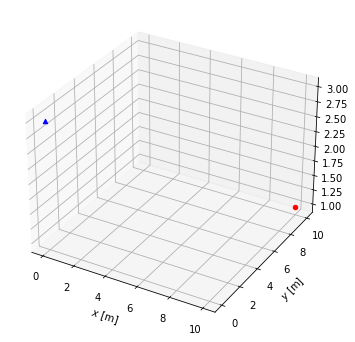

In [45]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
plt.ylabel("$y$ [m]")
plt.xlabel("$x$ [m]")
# plt.zlabel("$z$ [m]")

for i in range(n_bs):
    ax.scatter(BS[i][0], BS[i][1], BS[i][2], marker='^',color='blue')
for n in range(n_ue):
    ax.scatter(UE[n][0], UE[n][1], UE[n][2], marker='o',color='red')

Signal matrix $s(t)$:

In [47]:
P = inv_dbm(30)/n_f
# S(f) generated as a digital randomic diagonal matrix (with 1 or -1)
D = np.random.randint(low=0,high=2,size=n_f)*2-1
S = np.zeros([n_ue,n_f,n_f])
S[::] = np.diag(D)*np.sqrt(P)
#Noise
var_ruido = inv_dbm(-127)*Δf/2 
η = np.random.normal(0,np.sqrt(var_ruido))+1j*np.random.normal(0,np.sqrt(var_ruido))

# np.random.normal(0,np.sqrt(var_ruido))
# Received signal Y(f)
Y = H @ S + η

S_inv = np.linalg.inv(S)
R =  Y@S_inv

# for j in range(n_ue):
#     for i in range(n_bs):
#         R[j][i] = R[j][i]*np.exp(-1j*φ[j][i])

# Vector of delays
h = np.fft.ifft(R)

#Sample rate
fs = n_f*Δf
Ts = 1/fs
t = np.linspace(0,n_f-1,n_f)*Ts

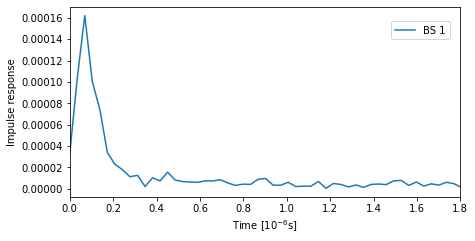

In [48]:
plt.figure(figsize=(7,3.5))

for i in range(n_bs):
    label = ('BS {}'.format(i+1))
    plt.plot(t*1e6,np.abs(h[0][i]),label=label)

plt.ylabel("Impulse response")
plt.xlabel("Time [$10^{-6}$s]")
plt.xlim(0,1.8)
plt.legend(bbox_to_anchor=(0.81, 0.95), loc='upper left')
# plt.grid()

In [67]:
c = 3e8 #m/s
τ_est = np.zeros([n_ue,n_bs])
D_est = np.zeros_like(τ_est)

for j in range(n_ue):
    i_τ = np.apply_along_axis(lambda i:np.argmax(np.abs(i)), 1, h[j])
    τ_est[j]=np.apply_along_axis(lambda k:t[k], 0, i_τ)
    D_est[j] = τ_est[j]*c

#True values:
τ = np.zeros_like(D_est)
for j in range(n_ue):
    for i in range(n_bs):
#         D[j][i]=np.linalg.norm(BS[i]-UE[j])
        τ[j][i]=np.min(H_q['cluster_delay'])
    D = τ*c

#Erro de distancia (metros)
erro_D = np.abs(D-D_est)

In [71]:
import pandas as pd

In [72]:
data = np.array([range(1,n_bs+1),τ_est[0]*(1e7), D_est[0], D[0], erro_D[0]]).transpose()
dados = pd.DataFrame(columns=['BS','$\tau$ estimated ($10^{-7}$ s)','D estimated (m)','D real (m)','Error distance (m)'],data=data)
dados = dados.set_index('BS')
dados.head(n_bs)

,$\tau$ estimated ($10^{-7}$ s),D estimated (m),D real (m),Error distance (m)
BS,,,,
1.0,0.694444,20.833333,14.292745,6.540589


#### Trilateration
$\mathbf{A} \mathbf{r}_{est} = \mathbf{b}$

In [74]:
r_est = np.zeros([n_ue,2])
d = np.zeros(2)

for j in range(n_ue):
#New denotations
    d = D_est[j]
    x = BS[:,0]
    y = BS[:,1]

    A = np.array([])
    b = np.array([])
    for i in np.arange(n_bs-1)+1:
        A = np.append(A,[2*(x[i]-x[0]),2*(y[i]-y[0])])
        b = np.append(b,(d[0]**2-d[i]**2)+(-x[0]**2-y[0]**2+x[i]**2+y[i]**2))
    A = A.reshape(n_bs-1,2)

    r_est[j] = np.linalg.inv(A.transpose()@A)@(A.transpose()@b)

LinAlgError: Singular matrix

In [75]:
r_est

array([[0., 0.]])

In [76]:
UE[::,:2]

array([[10, 10]])

In [ ]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

for n in range(n_ue):
    erro_range[n] = np.linalg.norm(UE[n,:2]-r_est[n])
    ax.scatter(UE[n][0], UE[n][1], marker='o',color='red', linewidths=2.75)
    ax.scatter(UE[n][0], UE[n][1], s=erro_range[n]*300, marker='o',edgecolor='blue',facecolor='none',linestyle='--', linewidths=2.5)
    ax.scatter(r_est[n][0], r_est[n][1], marker='o',color='green', linewidths=2.75)